## Fíjate cómo se carga y manipula una imagen como si fuera una matriz

tamano de la imagen (702, 1057)
83127


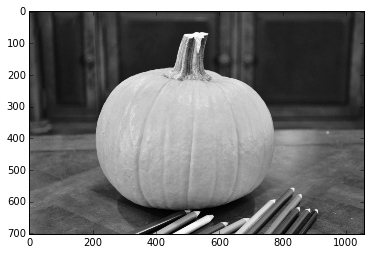

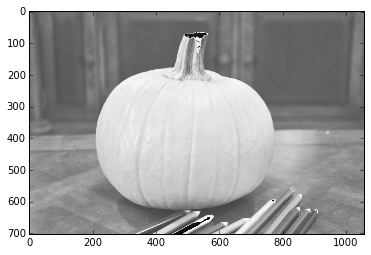

In [44]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

img = io.imread("imgs/pumpkin.jpg")
plt.imshow(img, cmap = plt.cm.Greys_r)
print "tamano de la imagen", img.shape

plt.figure()
plt.imshow(img+50, cmap = plt.cm.Greys_r)
print np.sum(img[701])

## Versión serie de nuestro algoritmo para difuminar la imagen

iter 0
iter 1
iter 2
iter 3
iter 4


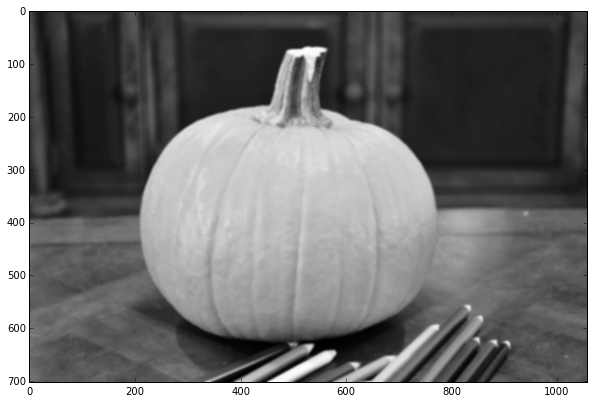

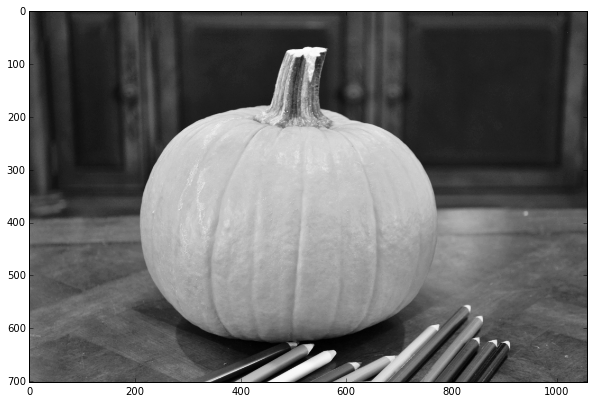

In [6]:
img = io.imread("imgs/pumpkin.jpg")
for i in range(10):
    print "iter",i
    img2 = np.copy(img)
    for y in range(1,img.shape[0]-1):
        for x in range(1,img.shape[1]-1):
            neig = img[y-1:y+2,x-1:x+2]
            img2[y,x] = np.mean(neig)
    img = img2
plt.figure(figsize=(10,8))
plt.imshow(img2, cmap = plt.cm.Greys_r)
plt.figure(figsize=(10,8))
img = io.imread("imgs/pumpkin.jpg")
plt.imshow(img, cmap = plt.cm.Greys_r)

# <font style="color:red">TAREA 1: Primera aproximación para distribuir la imagen por bandas a cada engine y que cada engine haga la operación de difuminado a su banda

In [3]:
import os,sys,time
import numpy as np

from IPython import parallel
rc = parallel.Client()
print "available engines", rc.ids
dv = rc.direct_view()
dv.clear()
dv.execute("import numpy as np")

available engines [8, 9, 10]


<AsyncResult: execute>

### <font style="color:red">Usa `dv.scatter` para distribuir la imagen entre los engines en una variable llamada `img_band` en cada engine

In [ ]:
### --- TU CODIGO AQUI ----
print "size of scattered bands", dv.apply(lambda: img_band.shape).get()

Copiamos en cada engine la banda de la imagen recibida para modificarla

In [6]:
def make_band_copy():
    global img_band_copy, img_band
    img_band_copy = np.copy(img_band)

In [7]:
dv.apply(make_band_copy).get()

[None, None, None]

In [8]:
print "size of scattered bands", dv.apply(lambda: img_band_copy.shape).get()

size of scattered bands [(234, 1057), (234, 1057), (234, 1057)]


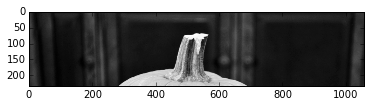

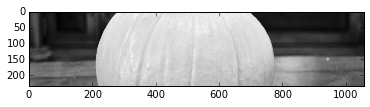

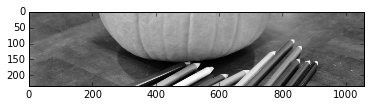

In [9]:
ims = dv["img_band_copy"]
for im in ims:
    plt.figure()
    plt.imshow(im, cmap = plt.cm.Greys_r)

Definimos y ejecutamos la operación de difuminado en cada banda

In [10]:
def blur_band(n_iters):
    global img2, img_band_copy
    for i in xrange(n_iters):
        img2 = np.copy(img_band_copy)
        for y in range(1,img_band_copy.shape[0]-1):
            for x in range(1,img_band_copy.shape[1]-1):
                neig = img_band_copy[y-1:y+2,x-1:x+2]
                img2[y,x] = np.mean(neig)
        img_band_copy = img2

### <font style="color:red">Usa `dv.apply` para ejecutar la función anterior en cada engine con 10 iteraciones sobre la porción de la banda que le toque

In [12]:
# --- TU CODIGO AQUI ----
r = ....

### <font style="color:red">Usa `dv.gather` para ensamblar en una variable local llamada `bimg` el contenido de las bandas procesadas en la variable `img_band_copy` de cada engine

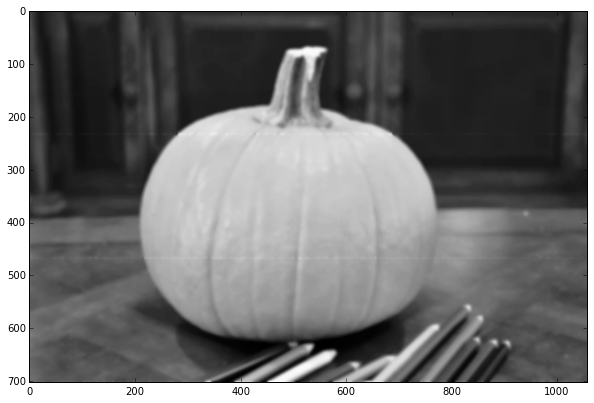

In [13]:
## --- TU CODIGO AQUI ----
bimg = ...
plt.figure(figsize=(10,8))
plt.imshow(bimg, cmap = plt.cm.Greys_r)

# <font style="color:red">TAREA 2: Arreglamos la implementación con comunicación entre engines

Primero, establecemos los cananles de comunicación directos entre los engines

In [5]:
with open ("utils/communicator.py", "r") as myfile:
    data=myfile.read()
dv.clear()

dv.execute("import numpy as np")

dv.scatter("my_id", rc.ids)
dv.execute("my_id = my_id[0]")
dv.push({"engine_list": np.array(rc.ids)})
dv.execute("my_seq_id = np.argwhere(engine_list==my_id)[0,0]")
dv.execute("import numpy as np; import pickle; import zlib")
           
dv.execute(data)
dv.execute("com = EngineCommunicator()")

# gather the connection information into a dict
ar = dv.apply_async(lambda : com.info)
peers = ar.get_dict()

# connect the engines to each other:
dv.apply_sync(lambda pdict: com.connect(pdict), peers);

Distribuimos la imagen y reservamos espacio en la estructura de datos de cada engine para el intercambio de filas

### <font style="color:red"> distribuye la imagen entre los engines con `dv.scatter` al igual que antes

In [74]:
# --- TU CODIGO AQUI ---
print "size of scattered bands", dv.apply(lambda: img_band.shape).get()

size of scattered bands [(234, 1057), (234, 1057), (234, 1057)]


### <font style="color:red">reserva espacio en cada banda para el intercambio de líneas de la imagen</font>

- Tendrás que copiar `img_band` en una nueva variable `img_band_copy`
- En la banda del engine 0 tendrás que añadir una fila al final de la banda
- En la banda del último engine tendrás que añadir una fila al principio
- En las demás tendrás que añadir una fila al principio y otra al final

Usa `my_seq_id` y `engine_list` para saber en qué engine se ejecuta tu código y el total de engines disponibles

In [75]:
def n_make_band_copy():
    global img_band_copy, img_band

    # --- TU CODIGO AQUI

In [76]:
dv.apply(n_make_band_copy).get()

[None, None, None]

In [77]:
print "space reserved for band", dv.apply(lambda: img_band_copy.shape).get()

space reserved for band [(235, 1057), (236, 1057), (235, 1057)]


### <font style="color:red">modifica el algoritmo para que intercambie filas directamente entre engines

- El primer engine envía su penúltima banda al siguiente engine y recibe la segunda (banda 1) del siguiente
- El último engine envíasu segunda banda al anterior y recibe la penúltima del anterior
- El resto de los engines hacen ambos pasos anteriores

In [78]:
def n_blur_band(n_iters):
    global img2, img_band_copy
    for i in xrange(n_iters):
        img2 = np.copy(img_band_copy).astype(int)
        
        # send lower row to next engine
        if my_seq_id!=len(engine_list)-1:
            
            # -- TU CODIGO AQUI: ENVIA LA PENULTIMA LINEA DE img_band_copy AL SIGUIENTE ENGINE
        
        if my_seq_id!=0:
            
            # -- TU CODIGO AQUI: RECIBE UNA LINEA Y REEMPLAZA CON ELLA LA LINEA 0 DE img_band_copy 

        # send upper row to previous engine
        if my_seq_id!=0:
            
            # -- TU CODIGO AQUI: ENVIA LA SEGUNDA LINEA (indice 1) DE img_band_copy AL ENGINE ANTERIOR
            
        if my_seq_id!=len(engine_list)-1:

            # -- TU CODIGO AQUI: RECIBE UNA LINEA Y REEMPLAZA CON ELLA LA ULTIMA LINEA (indice -1) DE img_band_copy 
            
        for y in range(1,img2.shape[0]-1):
            for x in range(1,img2.shape[1]-1):
                neig = img_band_copy[y-1:y+2,x-1:x+2]
                img2[y,x] = np.mean(neig)
                
        img_band_copy = img2

In [79]:
r = dv.apply(n_blur_band,3).get()

In [ ]:
bimg = dv.gather("img_band_copy").get()
plt.figure(figsize=(10,8))
plt.imshow(bimg, cmap = plt.cm.Greys_r)
print bimg.shape

### <font style="color:red">Ensambla correctamente las bandas descartando las filas introducidas anteriormente para el intercambio de filas entre bandas

In [ ]:
received_bands = dv["img_band_copy"]

# --- TU CODIGO AQUI
im = ...


plt.figure(figsize=(10,8))
plt.imshow(im, cmap = plt.cm.Greys_r)
print im.shape